## Add Aero Forces

need to add aero moments to my aero model will do for a simple model and check result with previous method

### Preamble

In [1]:
import sympy as sym
import sympy.physics.mechanics as me
import pandas as pd
import seaborn as sns

import numpy as np
from scipy.integrate import odeint,LSODA,BDF,solve_ivp
import matplotlib.pyplot as plt

import sys, os

sys.path.insert(1, os.path.join(sys.path[0], '..\..'))
import sympyTransforms as symt
import custom_plot_objects as cpo
import FwtModels as fm
import FwtModels.dof2 as dof2
import FwtModels.RollingModel as rm
import FwtModels.AeroModels as ams
import FwtModels.AssumedShapesNonLin as asnl

me.mechanics_printing()

In [2]:
sym.Symbol('M_thetadot')

### Define the Model

#### Create Parameter instance

In [3]:
half = sym.Rational(1,2)

# lets go for B2T2 (so 5 DoF)
p = fm.FwtParameters(2)

## Create some global parameters
p.c = fm.FwtVariable(0.15,'c') # chord of wing

# main Wing Structural Parameters
p.y_w = sym.Symbol('y')
p.x_w = sym.Symbol('x')

p.x_f = -p.c*half # flexural axis location
p.s = fm.FwtVariable(10,'s') # span
p.EI = fm.FwtVariable(1e9,'EI') # EI
p.GJ = fm.FwtVariable(1e7,'GJ') # GJ

p.m = fm.FwtVariable(30,'m_t') # inner wing mass
p.rho_w = p.m/(p.c*p.s) #wing density

## Aero Parameters
p.rho = fm.FwtVariable(1.225,'rho') # density
p.V = fm.FwtVariable(10,'V') # velocity
p.g  = fm.FwtVariable(9.81,'g') # gravity
p.alpha_r = fm.FwtVariable(np.deg2rad(3),'alpha_r') # root AoA

p.a_w = fm.FwtVariable(2*np.pi,'a_w') # C_L of wing
p.M_thetadot = fm.FwtVariable(1.2,'M_thetadot')


## force first bending mode frequency
p.f_0 = fm.FwtVariable(2,'f_0') # first Bending mode frequency
p.EI = (sym.Rational(2,3.516)*sym.pi*p.f_0)**2*p.rho_w*p.c*p.s**4

#### Create Transforms

In [4]:
#get shape functions for main wing
z_w,tau_w = asnl.ShapeFunctions_BN_TM(1,1,p.q,p.y_w,p.x_w,p.x_f,0)

#define wing frame
wing_frame = symt.HomogenousTransform()
#z_w = sym.Function('z_w')(p.q[0],p.q[1],p.y_w,p.x_w)
#create flexielement
M = fm.MassMatrix(p.m)
ele = fm.FlexiElement(wing_frame.Translate(p.x_w,p.y_w,z_w),sym.Matrix([0,tau_w,0]),M,p.x_w,p.y_w,z_w,p.c,p.s,p.x_f,p.EI,p.GJ)

#fwt_GravityForces = ams.GravityModel(p,fwt_frame.Translate(0,p.l_f,0),sym.Matrix([0,0,p.g*p.m_f]))
#wing_GravityForces = ams.GravityModel(p,wing_frame,sym.Matrix([0,0,p.g*p.m_w]))

#Aero Forces
#fwt_AeroForces = ams.AeroModelv2(p,fwt_frame.Translate(0,p.y_f,0),p.a_f,(p.y_f,0,p.s_f),ams.FwtAoA(p,p.q[2])+tau_f)

wing_frame_aero = wing_frame.Translate(p.x_f,p.y_w,z_w.subs(p.x_w,p.x_f))
wing_AeroForces = ams.AeroModelv3(p,wing_frame_aero,p.a_w,(p.y_w,0,p.s),p.alpha_r+tau_w,tau_w.diff(me.dynamicsymbols._t),p.M_thetadot)

#compistie force
CompositeForce = ams.CompositeForce(p,[])

sm = asnl.SymbolicModel([ele],p)

In [113]:
wing_frame_aero = symt.HomogenousTransform().Translate(0,p.y_w,z_w.subs(p.x_w,p.x_f)).R_y(tau_w)
wing_frame_aero.Transform_point(sym.Matrix([0,0,0])).diff(me.dynamicsymbols._t)
#wing_frame_aero.ManipJacobian(p.q)*p.qd
#wing_frame_aero.Transform_point([0,0,0])
#wing_frame_aero.E
#wing_frame_aero.E.diff(me.dynamicsymbols._t)*wing_frame_aero.Inverse().E

sym.Matrix([0,0,0,0,p.s,0])

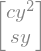

In [151]:

T = wing_frame.Translate(0,p.y_w,z_w.subs(p.x_w,p.x_f)).R_y(tau_w)
### THE ANSWER TO ALL MY PROBLEMS (small angles means inverabailty not true etc....)
(T.ManipJacobian(p.q)).T*sym.Matrix([0,0,p.c,0,p.s,0])
#T.Inverse().E*T.E.diff(me.dynamicsymbols._t)*sym.Matrix([0,0,0,1])

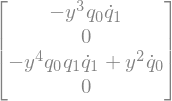

In [110]:
symt.Wedge(wing_frame.Translate(0,p.y_w,z_w.subs(p.x_w,p.x_f)).R_y_small(tau_w).ManipJacobian(p.q)*p.qd)*sym.Matrix([0,0,0,1])

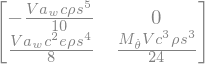

In [160]:
wing_frame_aero = wing_frame.Translate(0,p.y_w,z_w.subs(p.x_w,p.x_f)).R_y(tau_w)

alpha = p.alpha_r+tau_w
alphadot = tau_w.diff(me.dynamicsymbols._t)

# add z velocity due to motion
v_z_eff = sym.simplify(wing_frame.Translate(0,p.y_w,z_w.subs(p.x_w,p.x_f)).BodyVelocity()[2])

# combine to get effective AoA
dAlpha = alpha + v_z_eff/p.V

# Calculate the lift force
dL_w = -sym.Rational(1,2)*p.rho*p.V**2*p.c*p.a_w*dAlpha

p.e = fm.FwtVariable(10,'e') # span sym.Symbol('e')# p.c*sym.Rational(1,4)-p.x_f
#p.x_f = p.c*sym.Rational(1,4) - p.e 


# Calulate the pitching Moment
dM_w = sym.Rational(1,2)*p.rho*p.V**2*p.c**2
dM_w *= (p.e*p.a_w*dAlpha + p.M_thetadot*alphadot*p.c/(sym.Integer(4)*p.V))

tt = wing_frame.Translate(0,p.y_w,z_w.subs(p.x_w,p.x_f))
#q_L = (tt.ManipJacobian(p.q)).T*sym.Matrix([0,0,dL_w,0,0,0]).integrate((p.y_w,0,p.s)).jacobian(p.qd)
#q_L


((T.ManipJacobian(p.q)).T*sym.Matrix([0,0,dL_w,0,dM_w,0])).integrate((p.y_w,0,p.s)).jacobian(p.qd)

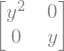

In [10]:
dofs = sym.Matrix([z_w.subs(p.x_w,p.x_f),tau_w])

force = sym.Matrix([[dL_w],[dM_w]])
Q = (dofs.jacobian(p.q).T*force).integrate((p.y_w,0,p.s))
Q.jacobian(p.qd)

dofs.jacobian(p.q)

#sym.simplify(((.T.jacobian(p.q).T)*sym.Matrix([[dL_w],[dM_w]])).integrate((p.y_w,0,p.s)).jacobian(p.qd))

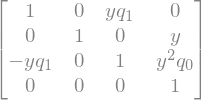

In [11]:
wing_frame.Translate(0,p.y_w,z_w.subs(p.x_w,p.x_f)).R_y_small(tau_w).E

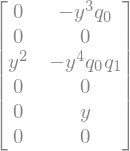

In [25]:

wing_frame_aero = wing_frame.Translate(0,p.y_w,z_w.subs(p.x_w,p.x_f)).R_y_small(tau_w)

alpha = p.alpha_r+tau_w
alphadot = tau_w.diff(me.dynamicsymbols._t)

# add z velocity due to motion
v_z_eff = wing_frame_aero.BodyVelocity()[2]

# combine to get effective AoA
dAlpha = alpha + v_z_eff/p.V

# Calculate the lift force
dL_w = -sym.Rational(1,2)*p.rho*p.V**2*p.c*p.a_w*dAlpha

e = sym.Symbol('e')# p.c*sym.Rational(1,4)-p.x_f

# Calulate the pitching Moment
dM_w = sym.Rational(1,2)*p.rho*p.V**2*p.c**2
dM_w *= (e*p.a_w*dAlpha + p.M_thetadot*alphadot*p.c/(sym.Integer(4)*p.V))




L = dL_w.integrate((p.y_w,0,p.s))
Mx = (dL_w*p.y_w).integrate((p.y_w,0,p.s))
My = (dM_w).integrate((p.y_w,0,p.s))

wing_frame_aero.ManipJacobian(p.q)

#wing_frame_aero.E.diff(p.q[1])*wing_frame_aero.Inverse().E

## create masses 

In [5]:
tmax, dt = 10, 0.01
# Initial conditions: theta, dtheta/dt, L, dL/dt

#params = p.GetNumericTuple()

#set velocity and alpha_r funcs
def Vfunc(t,x):
    return 25

def arfunc(t,x):
    return np.deg2rad(0)
    #return np.deg2rad(5)+np.sin(2*np.pi*1*t)*np.deg2rad(5)

p.V.value = Vfunc
p.alpha_r.value = arfunc

y0 = [0]*p.qs*2
y0[0] = 0.2
#y0 = [1.5,0,0.02,0]
ts = np.arange(0, tmax+dt, dt)

constraints = [np.NaN]*p.qs*2

def objectiveDeriv(t,y):
    deriv = sm.deriv(t,y,p.GetNumericTuple(y,t))
    return tuple(np.where(np.isnan(constraints),deriv,constraints))

In [6]:
objectiveDeriv(0,[0]*p.qs*2)
#[0]*int(len([0,0,0,0,0,0])/2)
#np.array([[0] for i in range(0,p.qs)])

IndexError: index 4 is out of bounds for axis 0 with size 4

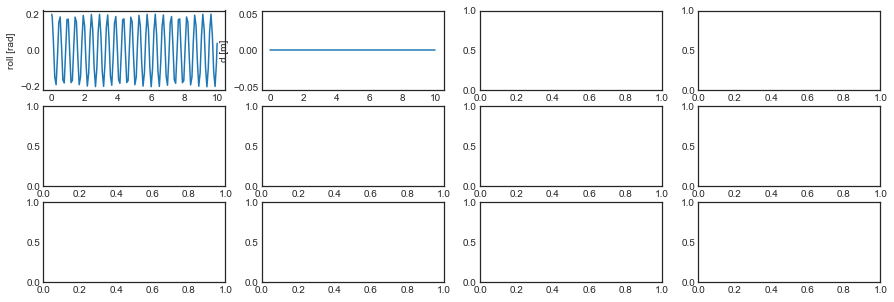

In [7]:
yData = solve_ivp(objectiveDeriv,(0,tmax),y0)

# interpolate data onto a uniform time grid

yi = yData.y
t = yData.t

plt.style.use('seaborn-white')
    
fig, axes = plt.subplots(3,4,figsize=(15,5))

# roll plot
axes[0][0].plot(t,yi[0])
axes[0][0].set_ylabel('roll [rad]')
axes[0][0].set_xlabel('t [s]')

# d plot
axes[0][1].plot(t,yi[2])
axes[0][1].set_ylabel('d [m]')
axes[0][1].set_xlabel('t [s]')

# theta plot
axes[0][2].plot(t,yi[4])
axes[0][2].set_ylabel('$\theta$ [rad]')
axes[0][2].set_xlabel('t [s]')


# theta plot
axes[0][3].plot(t,yi[6])
axes[0][3].set_ylabel('$\theta$ [rad]')
axes[0][3].set_xlabel('t [s]')

# ddot plot
axes[1][0].plot(t,yi[1])
axes[1][0].set_ylabel('$\dot{d}$ [m/s]')
axes[1][0].set_xlabel('t [s]')

# thetadot plot
axes[1][1].plot(t,yi[3])
axes[1][1].set_ylabel(r'$\dot{\theta}$ [rad/s]')
axes[1][1].set_xlabel('t [s]')

# thetadot plot
axes[1][2].plot(t,yi[5])
axes[1][2].set_ylabel(r'$\dot{\theta}$ [rad/s]')
axes[1][2].set_xlabel('t [s]')
# thetadot plot
axes[1][3].plot(t,yi[7])
axes[1][3].set_ylabel(r'$\dot{\theta}$ [rad/s]')
axes[1][3].set_xlabel('t [s]')